Run this notebook to approximate $\sin(x)$ with $y = {a} + {b} x + {c} x^2 + {d} x^3$.

In [2]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float32) # improved the speed when the parameters are float32
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
PI = math.pi

# Linear regression

Modify the number of samples and repeat the result.

In [3]:
num_samples = 5000
x = np.linspace(-PI, PI, num_samples)
x_rand = np.random.uniform(-PI, PI, num_samples)
y = np.sin(x)
y_rand = np.sin(x_rand)

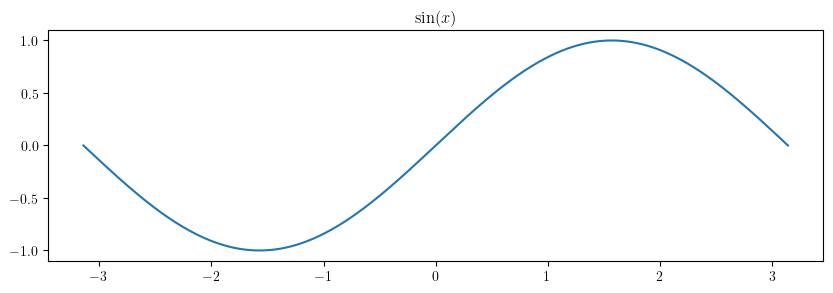

In [4]:
f = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(x, y)
plt.title(r'$\sin(x)$');

# Approximating a function with polynomials

- Comment the 3rd order term and see how it affects the approximation.

- Uncommment the 4th order term and see how it affects the approximation.

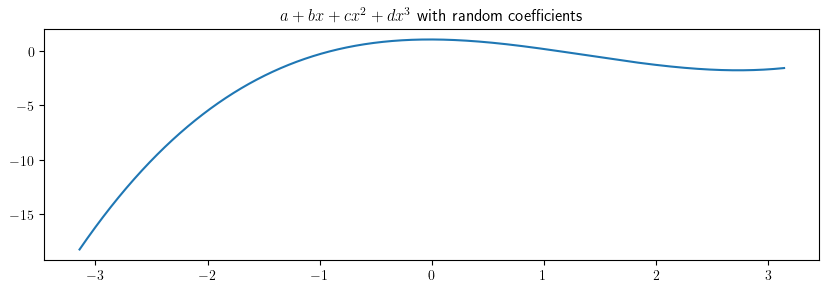

In [5]:
# Randomly initialize weights
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()
e = np.random.randn()
y_pred = a + b * x + c * x ** 2 + d * x ** 3 #+ e * x ** 4
f = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(x, y_pred)
plt.title(r'$a + b x + c x^2 + d x^3$ with random coefficients');


# Gradient descent method to find the best coefficients

- Modify the number of epochs from 100 and to 10000 to see how it affect the accuracy of the approximation.

- Modify learning rate and see how it affects the reslult.

In [6]:
learning_rate = 1e-6
num_epochs = 500000
# Precompute powers of x out of the loop for gaining efficiency
x2 = x ** 2
x3 = x ** 3
for t in range(num_epochs):
    # Forward pass: compute predicted y
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x2 + d * x3 #+ e * x ** 4

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    if t % 5000 == 5999:
        print(t, loss)

    # Backpropagation to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x2).sum()
    grad_d = (grad_y_pred * x3).sum()

    # Update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: $y = {a} + {b} x + {c} x^2 + {d} x^3$')

Result: $y = 3.469664413481941e-17 + 0.8568862855242932 x + -2.2338868822134492e-17 x^2 + -0.0933647579835181 x^3$


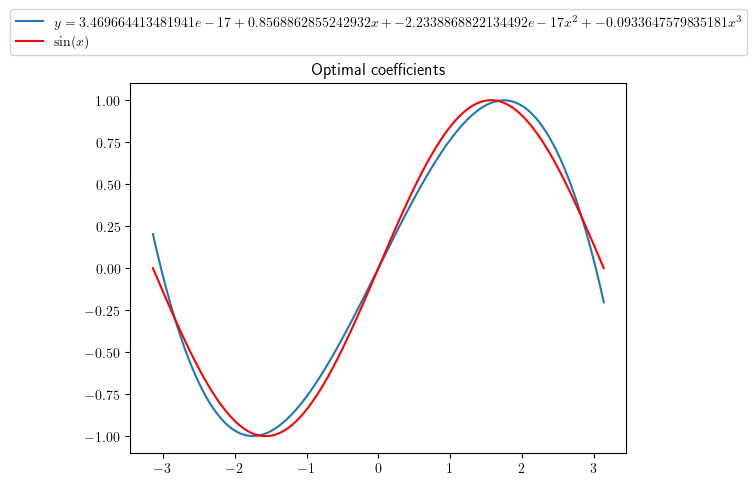

In [7]:
plt.plot(x, y_pred,label=f'$y = {a} + {b} x + {c} x^2 + {d} x^3$')
plt.plot(x, y, 'r',label=r'$\sin(x)$');
plt.legend(bbox_to_anchor=(.5, 1.2), loc='upper center', borderaxespad=0.);
plt.title(f'Optimal coefficients');

# Error

- $L^1$ 

- $L^2$

- $L^\infty$


In [8]:
print(rf'$L^1$ error: {np.abs(y_pred - y).sum()/num_samples:.5f}')
print(rf'$L^2$ error: {np.sqrt(np.square(y_pred - y).sum()/num_samples):.5f}')
print(fr'$L^\infty$ error: {np.abs(y_pred - y).max():.5f}')

$L^1$ error: 0.05771
$L^2$ error: 0.06631
$L^\infty$ error: 0.20291


In [9]:
print(rf'$L^1$ percentage error: {100*np.abs(y_pred - y).sum()/np.abs(y).sum():.5f}%')
print(rf'$L^2$ percentage error: {100*np.sqrt(np.square(y_pred - y).sum())/np.sqrt(np.square(y).sum()):.5f}%')
print(fr'$L^\infty$ percentage error: {100*np.abs(y_pred - y).max()/np.abs(y).max():.5f}%')

$L^1$ percentage error: 9.06659%
$L^2$ percentage error: 9.37911%
$L^\infty$ percentage error: 20.29059%


## Legendre polynomials and regression


Legendre polynomials are orthogonal polynomials for interval $[-\pi,\pi]$. Use regression formula for orthogonal polynomials to repeat the approximation in terms of Legendre polynomials. 

$$f(x)\approx\sum_k a_kP_k(x)$$

Find $a_k$ using the orthogonality of Legendre polynomials.

In [10]:
from numpy.polynomial import Legendre
from numpy.polynomial import Legendre

# Represents P_0(x) + 2*P_1(x) + 3*P_2(x)
coefs = np.array([1, 2, 3])
my_legendre = Legendre(coefs)
my_legendre(0.5)  # Evaluate at x = 0.5

1.625

In [11]:
c1 = np.array([1])
c2 = np.array([0, 1])
c3 = np.array([0, 0, 1])
c4 = np.array([0, 0, 0, 1])
l1 = Legendre(c1)
l2 = Legendre(c2)
l3 = Legendre(c3)
l4 = Legendre(c4)
(y*l1(x)).sum()/(l1(x)**2).sum(),(y*l2(x)).sum()/(l2(x)**2).sum(),(y*l3(x)).sum()/(l3(x)**2).sum(),(y*l4(x)).sum()/(l4(x)**2).sum()

(4.5474735088646414e-17, 0.3037811814288977, 0.0, 0.01134125076864305)

# Approximation of $\sin(x)$ with neural networks

## Defining a neural network in torch

In [25]:
num_neurons = 20 # Modify the number of neurons
num_neurons1 = 40 # Modify the number of neurons

model = torch.nn.Sequential(
            torch.nn.Linear(1, num_neurons),
            torch.nn.Tanh(),
            # torch.nn.Linear(num_neurons, num_neurons1), #Try different architectures
            # torch.nn.Tanh(),
            torch.nn.Linear(num_neurons,1),
        )

# Generate the number of samples

- Modify the number of samples

In [26]:
num_samples = 3000
x = torch.linspace(-math.pi, math.pi, num_samples).view(-1, 1)# Switch to random samples
# print(x.shape)
y = torch.sin(x)
# print(y.shape)
print(r'Explain the reason behind the shape of the variable $x$, i.e. {}.'.format(y.shape))

Explain the reason behind the shape of the variable $x$, i.e. torch.Size([3000, 1]).


- Modify the number of neurons 

- Modify the number of layers

- Modify the learning rate from 1e-6 to 1e-1

- Modify the number of epochs

In [28]:
num_epochs = 300
learning_rate = 1e-1
optimizer = optim.Adam(model.parameters(), learning_rate)
# optimizer2 = optim.SGD(model.parameters(), learning_rate,momentum=0.9)
for t in range(num_epochs):
    y_pred = model(x)
    # loss = torch.square(y_pred - y).sum().clone().detach().requires_grad_(True)
    loss = torch.nn.functional.mse_loss(model(x), y)
    model.zero_grad() # Zero the gradients before running the backward pass.
    # optimizer.zero_grad() # Zero the gradients before running the backward pass.
    loss.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    if t % 100 == 99:
        print(t, loss)
        # learning_rate /= t # Decay learning rate
    # with torch.no_grad(): # Update the weights using gradient descent. Each parameter is a Tensor, so
    #     for param in model.parameters(): # We can access its gradients like we did before.
    #         param -= learning_rate * param.grad # Update the weights using gradient descent
            
    optimizer.step() # Update the weights and biases using gradient descent. Each parameter is a Tensor. Equivalent to the above three lines, but more efficient.

99 tensor(3.0794e-05, grad_fn=<MseLossBackward0>)
199 tensor(1.2451e-05, grad_fn=<MseLossBackward0>)
299 tensor(7.7317e-06, grad_fn=<MseLossBackward0>)


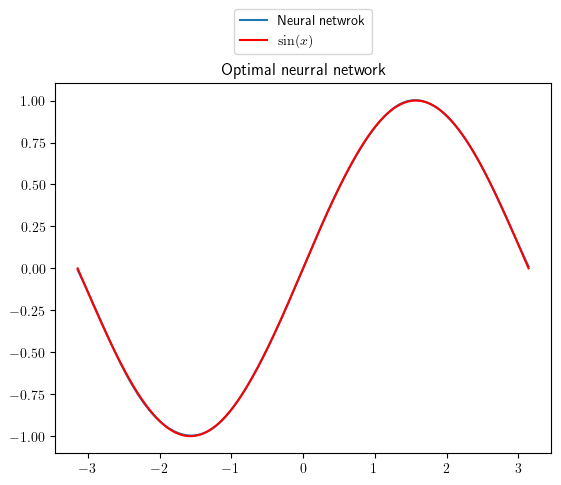

In [29]:
plt.plot(x.clone().detach(), model(x).clone().detach(),label=f'Neural netwrok')
plt.plot(x.clone().detach(), y.clone().detach(), 'r',label=r'$\sin(x)$');
plt.legend(bbox_to_anchor=(.5, 1.2), loc='upper center', borderaxespad=0.);
plt.title(f'Optimal neurral network');

In [30]:
print(rf'$L^1$ error: {torch.abs(y_pred - y).sum()/num_samples:.5f}')
print(rf'$L^2$ error: {torch.sqrt(torch.square(y_pred - y).sum()/num_samples):.5f}')
print(fr'$L^\infty$ error: {torch.abs(y_pred - y).max():.5f}')

$L^1$ error: 0.00218
$L^2$ error: 0.00278
$L^\infty$ error: 0.01236


In [23]:
print(rf'$L^1$ percentage error: {100*torch.abs(y_pred - y).sum()/torch.abs(y).sum():.5f}%')
print(rf'$L^2$ percentage error: {100*torch.sqrt(torch.square(y_pred - y).sum())/torch.sqrt(np.square(y).sum()):.5f}%')
print(fr'$L^\infty$ percentage error: {100*torch.abs(y_pred - y).max()/torch.abs(y).max():.5f}%')

$L^1$ percentage error: 0.79512%
$L^2$ percentage error: 0.78168%
$L^\infty$ percentage error: 1.72674%


# Comparison of third order polynomial and neural network

Set the number of samples and the number of epochs in both methods the same and set the number of neurons in the neural network such that the training time is approximately the same as in the polynomial approximation. Find out which method is more accurate.

# Higher dimensional example


Consider the function $f(x)=\sin\Big(\prod_{i=1}^dx^d\Big)$.

Repeat the above neural network reconstruction of function $f$ in dimension $d=10$.